# Day 2 Solutions

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from time import time

### Reading the lens/source catalog

In [2]:
!head -n 5 /home/idies/workspace/Storage/divyar/AstroTwin_Colo_2024/DataStore/demo_objects.csv

# !wc -l /home/idies/workspace/Storage/divyar/AstroTwin_Colo_2024/DataStore/demo_objects.csv

ra,dec
30.611734783139795,-6.3569091978972425
30.61078116389429,-6.350381359287763
30.596477830319948,-6.3461523588063935
30.592680083175416,-6.3445214768250775


In [3]:
#reading lens file

#tries to read everthing in the file
path="/home/idies/workspace/Storage/divyar/AstroTwin_Colo_2024/DataStore/demo_objects.csv"

df = pd.read_csv(path, sep=',')

\# select required columns only

In [4]:
df = pd.read_csv(path, sep=',', usecols=[0,1])

In [5]:
df.head()

,ra,dec
0,30.611735,-6.356909
1,30.610781,-6.350381
2,30.596478,-6.346152
3,30.592680,-6.344521
4,30.601111,-6.338650


### Visualising the coordinate space of input data

<div class="alert alert-info">

Exercise: 
    
- write a python code to plot dec(on Y-axis) vs ra(on X-axis) of the objects passed in the dataFrame.

    This plot will look very dense, so in order to visually see the points distributed on the (ra,dec) plane, downsample the number of points by 100 and again plot.
- In order to downsample the points, use `numpy.random.choice()` function.

</div>

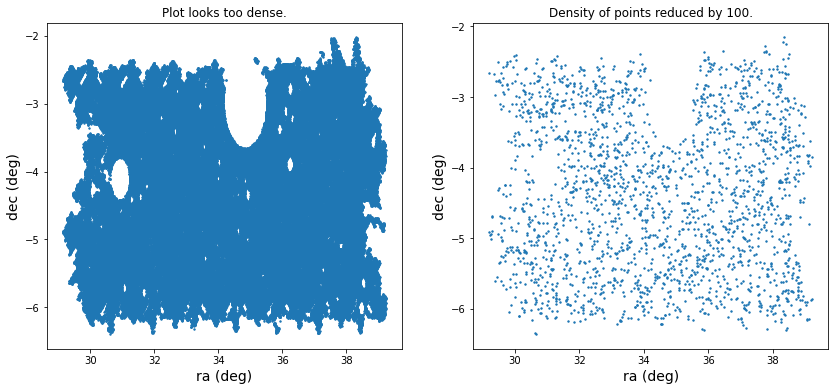

In [7]:
fig,ax = plt.subplots(1,2, figsize=(14,6))
ax1,ax2 = ax

#plot all the coordinates   
ax1.scatter(df.ra.values,df.dec.values, s=2)
ax1.set_xlabel("ra (deg)", fontsize=14)
ax1.set_ylabel("dec (deg)", fontsize=14)

ax1.set_title("Plot looks too dense.")

#Randomly picking up points to reduce the density of points
Number_of_points = df.ra.size
down_sample_by = 100
random_indices = np.random.choice(np.arange(Number_of_points), 
                                  size=int(Number_of_points/down_sample_by), 
                                  replace=False)
#plot down sampled number coordinates
ax2.scatter(df.ra.values[random_indices], df.dec.values[random_indices], s=2)
ax2.set_xlabel("ra (deg)", fontsize=14)
ax2.set_ylabel("dec (deg)", fontsize=14)
ax2.set_title("Density of points reduced by %d."%down_sample_by)

plt.show()

### `On-sky distance` between two points on the surface of a unit sphere

Given the spherical coordinate system, we can express the points in as

$\vec{r_i} = r_i \cdot (\sin(90 -\delta_i) \cos\alpha_i \ \hat{x}+ \sin(90 -\delta_i) \sin\alpha_i \ \hat{y} + \cos(90 -\delta_i) \ \hat{z})$, $\hspace{0.2cm}$for  $\mathrm{i \in (1,2)}$. Here $\alpha_i$ and $\delta_i$ are the right ascension and declination for $i^{\rm th}$ point.

We will first compute the cosine of the angle $\theta$ between the points using :

$\cos(\theta)=\frac{\vec{r_1}\cdot\vec{r_2}}{r_1 r_2}$ <br>

Given that these points are on a unit sphere we can set $r_1=r_2=1$ and get the value of $\theta$.

Using: $\mathrm{arc\_distance}=s=r \times \theta$, we obtain the distance between the two points having position($\alpha_1$, $\delta_1$) and ($\alpha_2$, $\delta_2$), respectively.

Since $r_1=r_2=1$, 

$\Rightarrow s=\theta$ (radians)

<div class="alert alert-info">

Exercise: Using the above formula

- Implement a function which takes tuples of (ra,dec) of two objects and returns the distance between them on the Unit sphere.

    Your code should return the result in units of arc seconds and **NOT** in radians.

</div>

In [38]:
rad_to_arcsec = 180.0*3600./np.pi
arcsec_to_rad = 1/rad_to_arcsec
deg_to_rad = np.pi/180. 

def dist_betw_two_obj(obj1,obj2):
    ra1,dec1 = obj1
    ra2,dec2 = obj2
    #convert angles from degree to radians
    ra1  = ra1  * deg_to_rad 
    ra2  = ra2  * deg_to_rad
    dec1 = dec1 * deg_to_rad
    dec2 = dec2 * deg_to_rad
    
    #calculate the distance in arcsec
    psi = np.cos(dec2)* np.cos(dec1)* np.cos(ra1-ra2) + np.sin(dec1)* np.sin(dec2)
    
    #due to precision errors, sometimes psi > 1 , e.g. 1.0000000000000000000001
    #in such a case np.arccos funciton will complaint. So handle that now.
    psi = np.clip(psi,-1,1)
        
    dist = np.arccos(psi)* rad_to_arcsec
    return dist


\# Running and testing the distance computation code:

In [39]:
# creating tuple of values from ra,dec of each object
coords = list( zip(df.ra.values,df.dec.values))
# print(coords[0])

In [40]:
print( f"""obj1 0: {coords[0]}
obj2 1: {coords[1]}
distance: {dist_betw_two_obj(coords[0],coords[1])} arcsec""") 

obj1 0: (30.611734783139795, -6.3569091978972425)
obj2 1: (30.61078116389429, -6.350381359287763)
distance: 23.7466131834144 arcsec


### Brute force search for neighbour objects within a specified distance 
time complexity ~ $\mathcal{O}(n^2)$ 

<div class="alert alert-info">

Exercise: 
    
1)
    
- Write a function `find_neighbour_points` that uses (ra,dec) coordinates of an object, and within some given `rmax` distance, finds its neighbour points in the given dataFrame catalog.

- Using this code you should be able to find neighbours of each object in the dataFrame - within the same dataFrame.

    Say the $1^{st}$ object in the dataFrame has 5 objects within say rmax=15 arcsec, then you should be able to  print/store the `indices` and `distances` of these neighbours.

2)
    
- Write a function `query_neighbour_points` that can use (ra,dec) coordinates of one object or an list/array of objets, and within some given `rmax` distance, finds its neighbour points in any other catalog.

- Using this code you should be able to access the coordinates of all the neighbours of each object that you are querying for. And hence you should be able to tell how far each neighbour is from the queried object.
    
</div>    

In [44]:
from collections import defaultdict

def find_neighbour_points(coords, rmax=10, verbose=True):
    """
    finding neighbour objects within some distance, for all the objects in a given array of coordinates.
    
    coords: an array/list of tuples (ra,dec)
    
    Returns:
    `nnids`: indices into `coords` of neighbours of each object in `coords` within `rmax`
    `distances`: distance of objects matched in `nnids"""

    # define containers for the distance and id information of matched objects
    distances = defaultdict(list)
    nnids = defaultdict(list)

    c=0
    for ii,obj1 in enumerate(coords):
        c+=1
        d=0
        for jj,obj2 in enumerate(coords):
            if jj==ii:
                continue
            d+=1
            dist = dist_betw_two_obj(obj1,obj2)
            if dist <= rmax:
                nnids[ii].append(jj)
                distances[ii].append(dist)
        if verbose:
            print(ii,nnids[ii],distances[ii])                
    return nnids,distances

def query_neighbour_points(coords1, coords2, rmax=10, verbose=True):
    """
    coords1: a tuple or an array/list of tuples (ra,dec)
    coords2: an array/list of tuples (ra,dec)
    
    Returns:
    `nnids`: indices into `coords2` of neighbours of each object `coords1` within `rmax`.
    `distances`: distance of objects matched in `nnids`"""

    coords1 = np.atleast_2d(coords1)
    
    # define containers for the distance and id information of matched objects
    distances = defaultdict(list)
    nnids = defaultdict(list)

    for ii,obj1 in enumerate(coords1):
        for jj,obj2 in enumerate(coords2):
            dist = dist_betw_two_obj(obj1,obj2)
            if 0<=dist <= rmax:
                nnids[ii].append(jj)
                distances[ii].append(dist)
                #print(obj1, obj2, ii,dist)
        if verbose:
            print(ii,nnids[ii],distances[ii])                
    return nnids,distances

#### Testing the above  `brute force search` functions 

<div class="alert alert-info">

Exercise: 

- Using the first 50 objects in the catalog, Search for their neighbours within a ball of radius `rmax`, say for `rmax`(default value)=15 arcsec.

    **Note:** We're only using 50 points in order to reduce the compute time, but the code has no such limitation. If you run your code for a large number of points, it will take more time to finish that's all.
    
    
- Access the above result and print indices,distances and coordinates of the neighbours of few objects.
    
- Then test out the function `query_neighbour_points` for the same objects you take above. The neighbour matches from `query_neighbour_points` and `find_neighbour_points` must match.
    
</div>

In [45]:
# Running and testing find_neighbour_points 

print("object index, neighbours indices list, neighbours distances list ")
%time nnids,distances = find_neighbour_points(coords[:50],rmax=15)

object index, neighbours indices list, neighbours distances list 
0 [] []
1 [] []
2 [3] [14.802299176580224]
3 [2] [14.802299176580224]
4 [36] [13.682331312465545]
5 [] []
6 [] []
7 [] []
8 [13] [9.465537930627812]
9 [10, 12, 38] [10.94680374083333, 5.876628853240463, 14.594679725290598]
10 [9, 12] [10.94680374083333, 10.280601486171243]
11 [42] [7.151725370768233]
12 [9, 10, 14] [5.876628853240463, 10.280601486171243, 11.314136132011965]
13 [8] [9.465537930627812]
14 [12, 15, 16] [11.314136132011965, 5.475958296970058, 11.765854084075805]
15 [14, 16, 44] [5.475958296970058, 13.47975484115049, 10.276694006812336]
16 [14, 15] [11.765854084075805, 13.47975484115049]
17 [46] [6.898087849306218]
18 [] []
19 [] []
20 [] []
21 [] []
22 [] []
23 [] []
24 [] []
25 [26] [13.29908354885402]
26 [25] [13.29908354885402]
27 [] []
28 [] []
29 [30] [3.6918325238285883]
30 [29] [3.6918325238285883]
31 [] []
32 [] []
33 [] []
34 [] []
35 [36] [10.896870606370635]
36 [4, 35] [13.682331312465545, 10.8968

In [46]:
# Running and testing query_neighbour_points
print("object index, neighbours indices list, neighbours distances list ")

# Remember because I have passed same object catalog as coords and coords2, 
# you are seeing same objects matched with each other. So if you ignore the same
# matches, you'll notice that the printed neighbours are exactly the same as shown in
# the above cell.

%time nnidss,distancess = query_neighbour_points(coords1=coords[:50],coords2=coords[:50],rmax=15)

object index, neighbours indices list, neighbours distances list 
0 [0] [0.003073585126505738]
1 [1] [0.0]
2 [2, 3] [0.003073585126505738, 14.802299176580224]
3 [2, 3] [14.802299176580224, 0.0]
4 [4, 36] [0.0, 13.682331312465545]
5 [5] [0.0]
6 [6] [0.0]
7 [7] [0.0]
8 [8, 13] [0.0, 9.465537930627812]
9 [9, 10, 12, 38] [0.0, 10.94680374083333, 5.876628853240463, 14.594679725290598]
10 [9, 10, 12] [10.94680374083333, 0.0, 10.280601486171243]
11 [11, 42] [0.0, 7.151725370768233]
12 [9, 10, 12, 14] [5.876628853240463, 10.280601486171243, 0.003073585126505738, 11.314136132011965]
13 [8, 13] [9.465537930627812, 0.0]
14 [12, 14, 15, 16] [11.314136132011965, 0.003073585126505738, 5.475958296970058, 11.765854084075805]
15 [14, 15, 16, 44] [5.475958296970058, 0.0, 13.47975484115049, 10.276694006812336]
16 [14, 15, 16] [11.765854084075805, 13.47975484115049, 0.0]
17 [17, 46] [0.0, 6.898087849306218]
18 [18] [0.0]
19 [19] [0.0]
20 [20] [0.0]
21 [21] [0.0]
22 [22] [0.0]
23 [23] [0.0]
24 [24] [0.0030

In [47]:
nth = 15

print("Using result of find_neighbour_points :")

print(f"""Accessing the neighbour points for the {nth}th object using the output 
of our brute force method:""")

print(f"neighbours: {nnids[nth]} \ndistances: {distances[nth]}")

print()

print(f"Accessing the neighbour coordinates of the {nth}th object:")
for ii in nnids[nth]:
    print(ii, coords[ii])

Using result of find_neighbour_points :
Accessing the neighbour points for the 15th object using the output 
of our brute force method:
neighbours: [14, 16, 44] 
distances: [5.475958296970058, 13.47975484115049, 10.276694006812336]

Accessing the neighbour coordinates of the 15th object:
14 (30.564297942270603, -6.322030429805476)
16 (30.562347805639572, -6.319398928221537)
44 (30.568297869918087, -6.3202347701814166)


---

#### A visual sanity check for execution of `find_neighbour_points`  function

<div class="alert alert-info">

Exercise:

- Plot the coordinates of the neighbours of any one test point. This exercise can help us visually inspect whether our neighbour search code gave us reasonable results or not.


- Along with plotting, also print the distances of each of these neighbours and visually confirm that the nearest looking object on the plot indeed has the smallest distance from the test point, and similarly check for other neighbour points.
    
</div>

I'm plotting the neighbours of $15^{th}$ point from the catalog.<br>
And also printing their `indices` and `distances` to compare the stored distances by eye!

Point marked as $\star$ is the $15^{th}$ point. Other points are its neighbours.

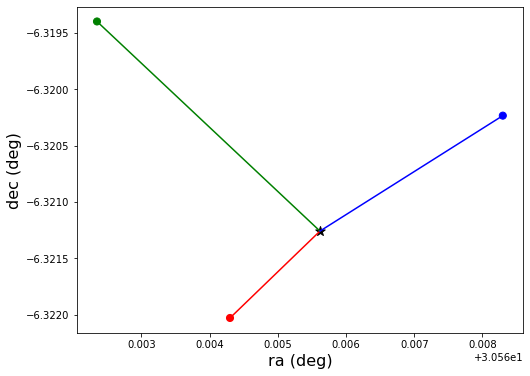

index--> distance		color
14 ---> 5.475958296970058 	 r
16 ---> 13.47975484115049 	 g
44 ---> 10.276694006812336 	 b


In [48]:
demoid = 15

plt.figure(figsize=(8,6))
#plot demo point
demora,demodec  = coords[demoid] 
plt.scatter(demora,demodec, c='black', s=100, marker=r'*')

#access all the neighbours
coords=np.array(coords)
neighbours = nnids[demoid]

#choose colors for a given number of neighbours
colors = ['r','g','b']
# colors = np.random.random( size=(len(neighbours),3) )

#plot all the neighbour points
plotra  = [coord[0] for coord in coords[neighbours] ]
plotdec = [coord[1] for coord in coords[neighbours] ] 
plt.scatter(plotra, plotdec, c=colors, s=50, marker='o')

for i in range(len(plotra)):
    plt.plot([demora,plotra[i]],[demodec,plotdec[i]] , c=colors[i])

plt.xlabel("ra (deg)", fontsize=16)
plt.ylabel("dec (deg)", fontsize=16)
plt.show()
#plt.savefig("neighbours_of_15th_obj.png",bbox_inches="tight")

# Now visuall compare the distances
print("index--> distance\t\tcolor")
ndist = distances[demoid]
for nidx,dist,c in zip(neighbours,ndist,colors):
    print(nidx,"--->",dist, '\t', c)

---

### Using k-d tree algorithm to query the neighbour points within a given distance 
time complexity ~ $\mathcal{O}(n\log{}n)$ 

In [49]:
from scipy import spatial
sin = np.sin
cos = np.cos
deg2rad = np.deg2rad

<div class="alert alert-info">

Exercise:
    
- Write a code using cKDTree to find out the neighbours of a given `set1` of objects (coordinates) from a catalog of other `set2` objects.
    
    Write this code in a `class structure` where it takes-in arrays of `ra,dec` of the catalog objects (set2) and 
    - converts (ra,dec) to (x,y,z) of cartesian coordinates,
    - creates k-d tree of the `set2` catalog objects using (x,y,z),
    - queries for the neighbour points of - each object in the `set1`, and returns the indices in `set2`.

</div>

In [50]:
class find_neighbours:
    def __init__(self, tra=None, tdec=None, r=1):
        """r==1 --> unit sphere calculations"""
        self.tra = tra
        self.tdec= tdec
        self.r = r
        self.rad_to_arcsec = 180.0*3600./np.pi
        self.arcsec_to_rad = 1/self.rad_to_arcsec
        
        print(f"Initializing with sphere of radius, r={r}.")
        
    # write a function that converts ra,dec to cartesian components.
    def RA_DEC_to_xyz(self, ra,dec, units='deg'):
        """converts ra,dec to cartesian x,y,z components on a unit sphere"""
        if units=="deg":
            ra = deg2rad(ra)
            dec= deg2rad(dec)
            
        x = self.r *cos(dec) *cos(ra)
        y = self.r *cos(dec) *sin(ra)
        z = self.r *sin(dec)
        return x,y,z 

    # write a function `create_tree` that takes arrays of ra,dec 
    # values as inputs and returns a cKDTree object into these coordinates.
    
    def create_tree(self):
        # create an array of tuples of x,y,z
        x,y,z = self.RA_DEC_to_xyz(self.tra,self.tdec)
        # make a tree using cKDTree method 
        tree = spatial.cKDTree(np.c_[x,y,z])
        return tree

    # write a function that takes arrays of ra,dec coordinates
    # and returns the neighbour object's indices from the tree 
    # within some distance `rmax` arcsec .
    
    def query_within_rmax(self, ra, dec, rmax=15, units="deg"):
        print(f"Searching for {ra.size} number of objects in the catalog with rmax={rmax} arcsec.")
        #convert rmax from arcsec to distance units
        rmax = self.r *rmax *self.arcsec_to_rad 
        
        # array of tuples of x,y,z of input objetcs
        x,y,z = self.RA_DEC_to_xyz(ra,dec)
        cartesian_coords = np.c_[x,y,z]

        # make tree from catalog
        tree = self.create_tree()
        
        # look for the neighbour objects
        ids_into_tree = tree.query_ball_point(cartesian_coords,rmax)
        
        return ids_into_tree

#### A sanity check

Testing conversion of (ra,dec) to (x,y,z) 

In [51]:
# Here we are not passing `tra` and `tdec` while initialising the class `find_neighbours`
# So these variables take default values of `None`. 
# We only want to test the coordinate conversion code `RA_DEC_to_xyz`. So it's ok to not 
# pass `tra`,`tdec`!

code = find_neighbours()

# a look at the cartesian coordinates
x,y,z = code.RA_DEC_to_xyz(coords[:,0], coords[:,1])
cartesian_coords = np.c_[x,y,z]

print("shapes of x,y,z arrays:",x.shape,y.shape,z.shape)
print("shapes of (x,y,z) tuple array:", cartesian_coords.shape)
#field on objects looks close to equator
cartesian_coords

Initializing with sphere of radius, r=1.
shapes of x,y,z arrays: (220622,) (220622,) (220622,)
shapes of (x,y,z) tuple array: (220622, 3)


array([[ 0.8553461 ,  0.50608675, -0.11072151],
       [ 0.85536537,  0.50607894, -0.11060828],
       [ 0.85549871,  0.50586954, -0.11053492],
       ...,
       [ 0.78796508,  0.6142163 , -0.04300421],
       [ 0.78737094,  0.61497898, -0.04298683],
       [ 0.78774839,  0.61449982, -0.04292369]])

#### Compare the output of our brute force algorithm with cKDTree algorithm on dew Demo objects

<div class="alert alert-info">

Exercise:

- Take the same bunch of objects for which we already have run our brute force search method, 

    feed them into the wrapper code of k-d tree written above, 
    
    find out their neighbour points within the same `rmax`(default value)=15 arcsec.
    
    The neighbour objects found from both the methods should match!


</div>

In [52]:
demo_ids = [15] #9,15
demo_ra =coords[demo_ids,0] #deg
demo_dec=coords[demo_ids,1] #deg

demox, demoy, demoz = code.RA_DEC_to_xyz(demo_ra, demo_dec)
demoobj = np.c_[demox,demoy,demoz]
print("""I had chosen following indices from set2(catalog) as my test objects:""",demo_ids)
print("coordinate of test objects:",demoobj)

# we want to look within `rmax` arcsec --> convert `rmax` from (arcsec) angle to length units

# rmax = 15 
# print()
# print(f"rmax={rmax} arcsec in radians --->",rmax* arcsec_to_rad)

I had chosen following indices from set2(catalog) as my test objects: [15]
coordinate of test objects: [[ 0.85581232  0.50543305 -0.11010311]]


\# This time Initialize class with by passing `tra` and `tdec` arguments and set up the tree

In [53]:
code_tree = find_neighbours(tra=coords[:,0], tdec=coords[:,1])

Initializing with sphere of radius, r=1.


\# Query the neighbours of demo objects 

In [54]:
idx=code_tree.query_within_rmax(demo_ra, demo_dec)

Searching for 1 number of objects in the catalog with rmax=15 arcsec.


\# Go back to brute force output and compare this result.... does it match? 

In [55]:
idx

array([list([14, 15, 16, 44])], dtype=object)

### Compare the computer time required by our brute force algorithm vs the k-d tree algorithm 

First let's use k-d tree to query neighbours within `rmax`=15 arcsec for each object within the catalog.

In [56]:
%time idx=code_tree.query_within_rmax(coords[:,0], coords[:,1])

Searching for 220622 number of objects in the catalog with rmax=15 arcsec.
CPU times: user 1.89 s, sys: 90.9 ms, total: 1.98 s
Wall time: 1.97 s


Reminder: full catalog has about 2,20,000 objects... and k-d tree found neighbours for each one of them in 1-2 seconds. (This time will vary depending on your computer's ability.)

Now let's use the brute force method only for 1000 objects.

In [57]:
%time nnids,distances = query_neighbour_points(coords[:1000], coords[:1000], rmax=15, verbose=False)

CPU times: user 1min 47s, sys: 348 ms, total: 1min 47s
Wall time: 1min 47s


You will notice that as the number of points to search for increases in `set1`, the performance of the k-d tree algorithm will keep on improving over the brute force method. 

That's just because the time required by k-d tree will grow as $\sim \mathcal{O}(n_1\log{n_2})$ where as that of brute force will grow as $\sim n_1 n_2$.

### Congratulations! Now you have learnt to - 

- use `cKDTree` to find out neighbours of a given `set1` of objects into some other `set2` of objects.

- count the number of neighbours of any given object in `set1`. 

- access the results of cKDTree and identify neighbours of each obejct in `set1` into the `set2`.

- access the coordinates and distances of each neighbour of every point in `set1`.